Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [24]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [25]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [26]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Test')

In [27]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2011
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [28]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [29]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2511 files belonging to 9 classes.
Using 2009 files for training.


In [30]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 2511 files belonging to 9 classes.
Using 502 files for validation.


In [31]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

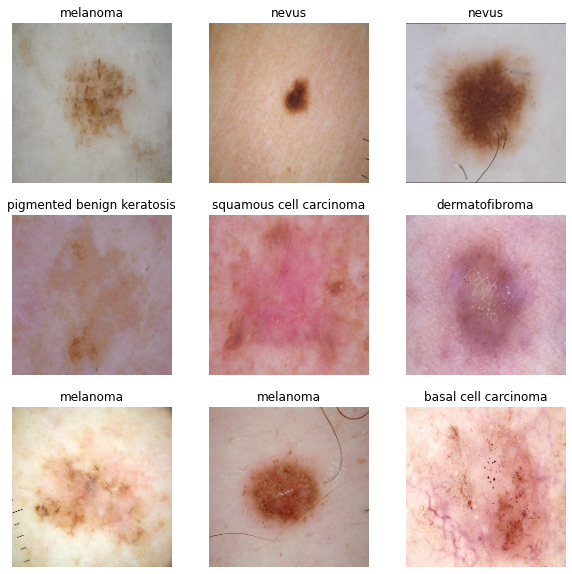

In [33]:
import matplotlib.pyplot as plt

### our code goes here, you can use training or validation data to visualize
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [35]:
### Your code goes here
num_classes = 9
model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape= (img_height, img_width, 3)),
layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
layers.MaxPool2D(),
layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
layers.MaxPool2D(),
layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
layers.MaxPool2D(),
layers.Flatten(),
layers.Dense(128, activation = 'relu'),
layers.Dense(num_classes)
])



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [36]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,),
              metrics=['accuracy'])

In [37]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [38]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
63/63 [==============================] - 70s 287ms/step - loss: 1.9177 - accuracy: 0.3390 - val_loss: 1.4941 - val_accuracy: 0.5020
Epoch 2/20
63/63 [==============================] - 1s 21ms/step - loss: 1.4561 - accuracy: 0.4898 - val_loss: 1.3032 - val_accuracy: 0.5618
Epoch 3/20
63/63 [==============================] - 1s 22ms/step - loss: 1.2129 - accuracy: 0.5784 - val_loss: 1.3338 - val_accuracy: 0.5996
Epoch 4/20
63/63 [==============================] - 1s 21ms/step - loss: 1.0870 - accuracy: 0.6187 - val_loss: 1.2662 - val_accuracy: 0.5717
Epoch 5/20
63/63 [==============================] - 1s 20ms/step - loss: 1.0733 - accuracy: 0.6247 - val_loss: 1.3515 - val_accuracy: 0.5618
Epoch 6/20
63/63 [==============================] - 1s 20ms/step - loss: 0.9674 - accuracy: 0.6531 - val_loss: 1.2807 - val_accuracy: 0.6295
Epoch 7/20
63/63 [==============================] - 1s 20ms/step - loss: 0.8724 - accuracy: 0.6864 - val_loss: 1.2331 - val_accuracy: 0.6434
Epoch 8/20


### Visualizing training results

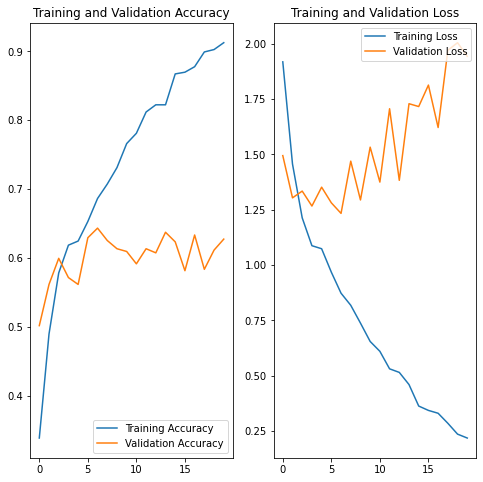

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
1. Epochs 20 :  After the end of epochs 20, the training accuracy and val_accuracy clearly shows that the model has been overfitted
2. Visualization : 
In the First Graph : After the visualization, we can see that the graphs indicates that traning accuracy is increased however the validation accuracy seems to be not increasing as much as training accuracy. 
In the second graph, the training loss has decreased but validation loss is increased. This graphs clearly tells a story that the model has overfitted and learnt the traninig dataset well but not performing well on validation dataset as much as it should.
This is my observation from this visualization and we need to play with hyperparameters and use other techniques to ensure model does not overfit.
Overfitting occurs when a model is too complex and performs well on the training data but poorly on new, unseen data. 

### Write your findings here

In [40]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape= (img_height, img_width, 3)),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
])

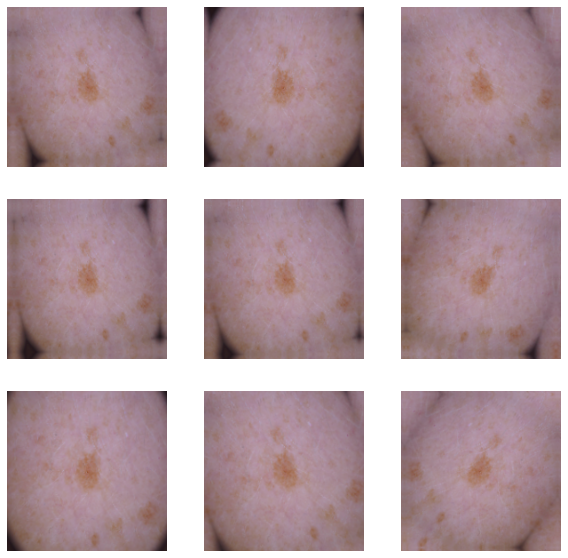

In [41]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")



### Todo:
### Create the model, compile and train the model


In [42]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([data_augmentation,
                   layers.experimental.preprocessing.Rescaling(1./255), 
                   layers.Conv2D(16,3, padding = 'same', activation = 'relu'),
                   layers.MaxPool2D(),
                   layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
                   layers.MaxPool2D(),
                   layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
                   layers.MaxPool2D(),
                   layers.Dropout(0.2),
                   layers.Flatten(),
                   layers.Dense(128, activation = 'relu'),
                   layers.Dense(num_classes)])


### Compiling the model

In [43]:
## Your code goes here
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [44]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(train_ds, 
                    batch_size=batch_size, 
                    epochs=20, 
                    validation_data=val_ds)

Epoch 1/20


63/63 [==============================] - 16s 176ms/step - loss: 1.9099 - accuracy: 0.3290 - val_loss: 1.6565 - val_accuracy: 0.5100
Epoch 2/20
63/63 [==============================] - 9s 139ms/step - loss: 1.4328 - accuracy: 0.5236 - val_loss: 1.4168 - val_accuracy: 0.5299
Epoch 3/20
63/63 [==============================] - 10s 159ms/step - loss: 1.2696 - accuracy: 0.5615 - val_loss: 1.6078 - val_accuracy: 0.5080
Epoch 4/20
63/63 [==============================] - 10s 159ms/step - loss: 1.2168 - accuracy: 0.5684 - val_loss: 1.3077 - val_accuracy: 0.6116
Epoch 5/20
63/63 [==============================] - 9s 143ms/step - loss: 1.1448 - accuracy: 0.5958 - val_loss: 1.3023 - val_accuracy: 0.5837
Epoch 6/20
63/63 [==============================] - 9s 139ms/step - loss: 1.0819 - accuracy: 0.6177 - val_loss: 1.2572 - val_accuracy: 0.5996
Epoch 7/20
63/63 [==============================] - 10s 158ms/step - loss: 1.0688 - accuracy: 0.6252 - val_loss: 1.2620 - val_accuracy: 0.6076
Epoch 8/20
63

### Visualizing the results

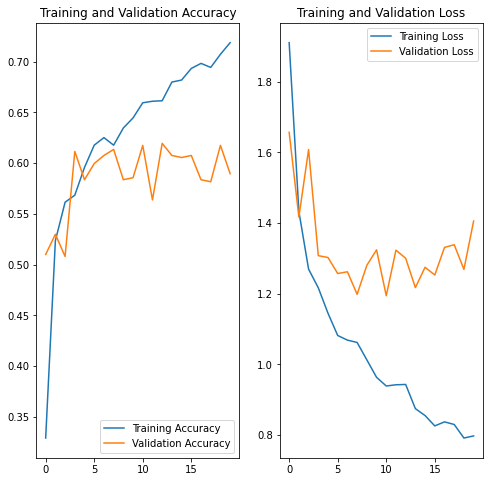

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. Epochs 20 :  After the end of epochs 20, the training accuracy and val_accuracy clearly shows that the model has been overfitted
2. Visualization : 
In the First Graph : After the visualization, we can see that the graphs indicates that traning accuracy is increased however the validation accuracy seems to be not increasing as much as training accuracy. 
In the second graph, the training loss has decreased but validation loss is increased. This graphs clearly tells a story that the model has overfitted and learnt the traninig dataset well but not performing well on validation dataset as much as it should.
This is my observation from this visualization and we need to play with hyperparameters and use other techniques to ensure model does not overfit.
Overfitting occurs when a model is too complex and performs well on the training data but poorly on new, unseen data. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [46]:
## Your code goes here.
import glob

class_counts = {}

for class_dir in glob.glob(f'{data_dir_train}/*'):
    class_name = class_dir.split('/')[-1] 
    class_counts[class_name] = len(glob.glob(class_dir + '/*.jpg'))

print(class_counts)


{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'pigmented benign keratosis': 234, 'nevus': 357, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


In [47]:
import pandas as pd

class_counts_df = pd.DataFrame(list(class_counts.items()), columns = ["class", "counts"])
print(class_counts_df)

                        class  counts
0           actinic keratosis     114
1        basal cell carcinoma     376
2              dermatofibroma      95
3                    melanoma     438
4  pigmented benign keratosis     234
5                       nevus     357
6        seborrheic keratosis      77
7     squamous cell carcinoma     181
8             vascular lesion     139


In [48]:
class_counts_df.sort_values(by = 'counts', ascending = False)


,class,counts
3,melanoma,438
1,basal cell carcinoma,376
5,nevus,357
4,pigmented benign keratosis,234
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


In [49]:
total_count = sum(class_counts.values())
class_percentages = {class_name: count/total_count * 100 for class_name, count in class_counts.items()}
class_percentages 

{'actinic keratosis': 5.668821481849826,
 'basal cell carcinoma': 18.697165589259075,
 'dermatofibroma': 4.724017901541522,
 'melanoma': 21.780208851317752,
 'pigmented benign keratosis': 11.63600198906017,
 'nevus': 17.75236200895077,
 'seborrheic keratosis': 3.82894082545997,
 'squamous cell carcinoma': 9.000497265042268,
 'vascular lesion': 6.911984087518648}

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Seborrheic Keratosis as per my code contains least number of samples with 77
#### - Which classes dominate the data in terms proportionate number of samples?
Melanoma with 438 dominates the samples in the dataset as per my code above.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [50]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [51]:
path_to_training_dataset= str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8BF6187460>: 100%|██████████| 500/500 [00:25<00:00, 19.73 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8BF613F3D0>: 100%|██████████| 500/500 [00:27<00:00, 18.18 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8C963EA910>: 100%|██████████| 500/500 [00:20<00:00, 24.07 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F8D1DA27A60>: 100%|██████████| 500/500 [01:52<00:00,  4.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F8C80104B80>: 100%|██████████| 500/500 [01:29<00:00,  5.57 Samples/s]


Initialised with 234 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8D1DA428B0>: 100%|██████████| 500/500 [00:20<00:00, 23.87 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8BF9CBC6A0>: 100%|██████████| 500/500 [00:49<00:00, 10.10 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8C97C65820>: 100%|██████████| 500/500 [00:24<00:00, 20.19 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8D1DA35550>: 100%|██████████| 500/500 [00:21<00:00, 23.33 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [52]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [53]:
# path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:2]

['/content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_88ec4425-a5fd-4c54-9ab3-501b7f8c58eb.jpg',
 '/content/gdrive/MyDrive/ML Projects/Project_Melanoma_Detection_CNN/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_d97d3d36-0ce7-4a9d-82e9-2645e97c013a.jpg']

In [54]:
# lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list[:2]

['actinic keratosis', 'actinic keratosis']

In [55]:
dataframe_dict_new = dict(zip(path_list, lesion_list))


In [56]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,/content/gdrive/MyDrive/ML Projects/Project_Me...,actinic keratosis
1,/content/gdrive/MyDrive/ML Projects/Project_Me...,actinic keratosis
2,/content/gdrive/MyDrive/ML Projects/Project_Me...,actinic keratosis
3,/content/gdrive/MyDrive/ML Projects/Project_Me...,actinic keratosis
4,/content/gdrive/MyDrive/ML Projects/Project_Me...,actinic keratosis
...,...,...
4995,/content/gdrive/MyDrive/ML Projects/Project_Me...,vascular lesion
4996,/content/gdrive/MyDrive/ML Projects/Project_Me...,vascular lesion
4997,/content/gdrive/MyDrive/ML Projects/Project_Me...,vascular lesion
4998,/content/gdrive/MyDrive/ML Projects/Project_Me...,vascular lesion


In [57]:
# create a dataframe of image paths and corresponding labels
df = pd.DataFrame({'Path': path_list, 'Label': [os.path.basename(os.path.dirname(os.path.dirname(x))) for x in path_list]})


df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.DataFrame({'Path': path_list, 'Label': lesion_list})
df = pd.concat([df, new_df], axis=0)

# get the value counts of each class
class_counts = df['Label'].value_counts()

print(class_counts)

vascular lesion               2000
actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
melanoma                      1000
pigmented benign keratosis    1000
nevus                         1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
Name: Label, dtype: int64


In [58]:
new_df.head()

,Path,Label
0,/content/gdrive/MyDrive/ML Projects/Project_Me...,actinic keratosis
1,/content/gdrive/MyDrive/ML Projects/Project_Me...,actinic keratosis
2,/content/gdrive/MyDrive/ML Projects/Project_Me...,actinic keratosis
3,/content/gdrive/MyDrive/ML Projects/Project_Me...,actinic keratosis
4,/content/gdrive/MyDrive/ML Projects/Project_Me...,actinic keratosis


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [59]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [60]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7011 files belonging to 9 classes.
Using 5609 files for training.


#### **Todo:** Create a validation dataset

In [61]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7011 files belonging to 9 classes.
Using 1402 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [62]:
## your code goes here
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3)),
                    layers.Conv2D(32, 3,padding="same",activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(64, 3,padding="same",activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(128, 3,padding="same",activation='relu'),
                    layers.MaxPool2D(),
                    layers.Dropout(0.15),
                    layers.Conv2D(256, 3,padding="same",activation='relu'),
                    layers.MaxPool2D(),
                    layers.Dropout(0.20),
                    layers.Conv2D(512, 3,padding="same",activation='relu'),
                    layers.MaxPool2D(),
                    layers.Dropout(0.25),
                    layers.Flatten(),
                    layers.Dense(1024,activation="relu"),
                    layers.Dense(units=num_classes, activation= 'softmax')])        
                                                
                              

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [63]:
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [64]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


176/176 [==============================] - 50s 254ms/step - loss: 2.0364 - accuracy: 0.2401 - val_loss: 1.5916 - val_accuracy: 0.4016
Epoch 2/50
176/176 [==============================] - 36s 196ms/step - loss: 1.5758 - accuracy: 0.3831 - val_loss: 1.5462 - val_accuracy: 0.3894
Epoch 3/50
176/176 [==============================] - 35s 192ms/step - loss: 1.4006 - accuracy: 0.4561 - val_loss: 1.2803 - val_accuracy: 0.4708
Epoch 4/50
176/176 [==============================] - 36s 200ms/step - loss: 1.2786 - accuracy: 0.4974 - val_loss: 1.2000 - val_accuracy: 0.5007
Epoch 5/50
176/176 [==============================] - 37s 203ms/step - loss: 1.1959 - accuracy: 0.5349 - val_loss: 1.1379 - val_accuracy: 0.5428
Epoch 6/50
176/176 [==============================] - 39s 217ms/step - loss: 1.0842 - accuracy: 0.5766 - val_loss: 0.9733 - val_accuracy: 0.6034
Epoch 7/50
176/176 [==============================] - 35s 194ms/step - loss: 1.0059 - accuracy: 0.6106 - val_loss: 0.8816 - val_accuracy: 0.6

#### **Todo:**  Visualize the model results

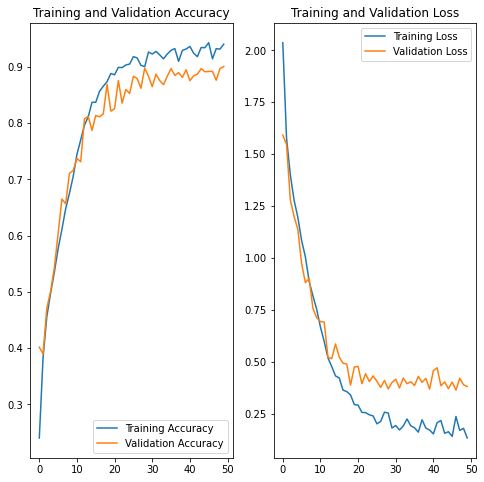

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Conclusion : After performing class imbalance technique and adding 500 samples to the existing images using Data Augmentor, we are able to derive perfect results and yes, we are able to get rid of Overfitting problem and the model has provided following results:
1. Loss has been minimized 
2. Training accuracy of 94% achieved
3. Validation Accuracy of 90% achieved